# Stat tests

Pairwise confidence intervals saved to 'pairwise_confidence_intervals.csv'.


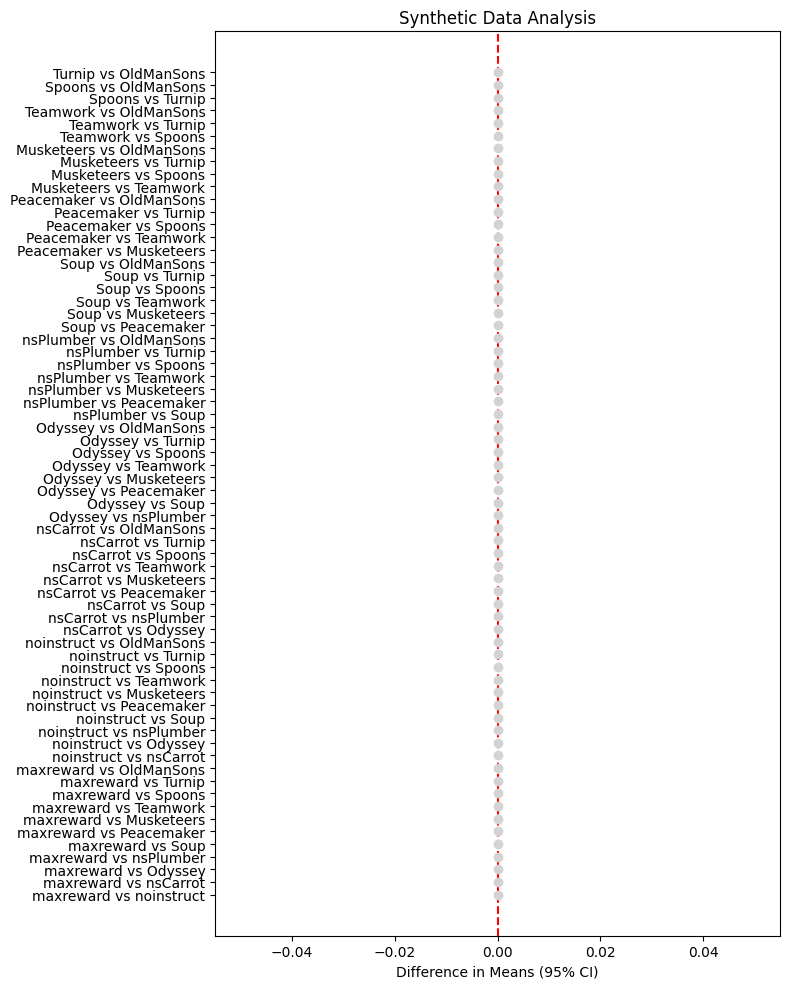

Matrix plot skipped: no valid pairs in matrix.


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma
import matplotlib.colors as colors

# Fixed pair ordering
fixed_pairs_regular = [
    ("Turnip", "OldManSons"),
    ("Spoons", "OldManSons"),
    ("Spoons", "Turnip"),
    ("Teamwork", "OldManSons"),
    ("Teamwork", "Turnip"),
    ("Teamwork", "Spoons"),
    ("Musketeers", "OldManSons"),
    ("Musketeers", "Turnip"),
    ("Musketeers", "Spoons"),
    ("Musketeers", "Teamwork"),
    ("Peacemaker", "OldManSons"),
    ("Peacemaker", "Turnip"),
    ("Peacemaker", "Spoons"),
    ("Peacemaker", "Teamwork"),
    ("Peacemaker", "Musketeers"),
    ("Soup", "OldManSons"),
    ("Soup", "Turnip"),
    ("Soup", "Spoons"),
    ("Soup", "Teamwork"),
    ("Soup", "Musketeers"),
    ("Soup", "Peacemaker"),
    ("nsPlumber", "OldManSons"),
    ("nsPlumber", "Turnip"),
    ("nsPlumber", "Spoons"),
    ("nsPlumber", "Teamwork"),
    ("nsPlumber", "Musketeers"),
    ("nsPlumber", "Peacemaker"),
    ("nsPlumber", "Soup"),
    ("Odyssey", "OldManSons"),
    ("Odyssey", "Turnip"),
    ("Odyssey", "Spoons"),
    ("Odyssey", "Teamwork"),
    ("Odyssey", "Musketeers"),
    ("Odyssey", "Peacemaker"),
    ("Odyssey", "Soup"),
    ("Odyssey", "nsPlumber"),
    ("nsCarrot", "OldManSons"),
    ("nsCarrot", "Turnip"),
    ("nsCarrot", "Spoons"),
    ("nsCarrot", "Teamwork"),
    ("nsCarrot", "Musketeers"),
    ("nsCarrot", "Peacemaker"),
    ("nsCarrot", "Soup"),
    ("nsCarrot", "nsPlumber"),
    ("nsCarrot", "Odyssey"),
    ("noinstruct", "OldManSons"),
    ("noinstruct", "Turnip"),
    ("noinstruct", "Spoons"),
    ("noinstruct", "Teamwork"),
    ("noinstruct", "Musketeers"),
    ("noinstruct", "Peacemaker"),
    ("noinstruct", "Soup"),
    ("noinstruct", "nsPlumber"),
    ("noinstruct", "Odyssey"),
    ("noinstruct", "nsCarrot"),
    ("maxreward", "OldManSons"),
    ("maxreward", "Turnip"),
    ("maxreward", "Spoons"),
    ("maxreward", "Teamwork"),
    ("maxreward", "Musketeers"),
    ("maxreward", "Peacemaker"),
    ("maxreward", "Soup"),
    ("maxreward", "nsPlumber"),
    ("maxreward", "Odyssey"),
    ("maxreward", "nsCarrot"),
    ("maxreward", "noinstruct")
]

fixed_pairs_temp = fixed_pairs_regular.copy()

def generate_synthetic_data(n_categories=10, n_samples=100, seed=42):
    np.random.seed(seed)
    data = {}
    true_params = {}
    for i in range(n_categories):
        mu = np.random.uniform(0, 10)
        var = np.random.uniform(0.1, 0.5)
        sigma = np.sqrt(var)
        values = np.random.normal(loc=mu, scale=sigma, size=n_samples)
        cat_name = f"Cat_{i+1}"
        data[cat_name] = values
        true_params[cat_name] = {"mu": mu, "variance": var}
    return data, true_params

def analyze_data(data,
                 csv_filename="pairwise_confidence_intervals.csv",
                 ci_plot_filename="pairwise_CI_plot.png",
                 matrix_plot_filename="pairwise_matrix.png",
                 n_bootstrap=1000,
                 subtitle="",
                 fixed_pairs=None):
    """
    Computes bootstrapped 95% CIs, saves CSV, plots error bars and matrix.
    """

    def bootstrap_diff(data1, data2, n_bootstrap=n_bootstrap):
        diffs = []
        n1, n2 = len(data1), len(data2)
        for _ in range(n_bootstrap):
            sample1 = np.random.choice(data1, size=n1, replace=True)
            sample2 = np.random.choice(data2, size=n2, replace=True)
            diffs.append(np.mean(sample2) - np.mean(sample1))
        lower = np.percentile(diffs, 2.5)
        upper = np.percentile(diffs, 97.5)
        return lower, upper

    if fixed_pairs is None:
        sample_means = {cat: np.mean(vals) for cat, vals in data.items()}
        sorted_categories = sorted(sample_means, key=sample_means.get)
        pair_comparisons = [(sorted_categories[i], sorted_categories[j])
                            for i in range(len(sorted_categories))
                            for j in range(i+1, len(sorted_categories))]
        unique_ordering = sorted_categories
    else:
        pair_comparisons = fixed_pairs
        unique_ordering = []
        for a, b in fixed_pairs:
            if a not in unique_ordering:
                unique_ordering.append(a)
            if b not in unique_ordering:
                unique_ordering.append(b)

    results = []
    for (cat1, cat2) in pair_comparisons:
        if cat1 not in data or cat2 not in data:
            results.append({
                "Category1": cat1, "Category2": cat2,
                "Lower_bound": np.nan, "Upper_bound": np.nan
            })
            print(f"Warning: {cat1} or {cat2} not found in data. CIs set to NaN.")
        else:
            if np.mean(data[cat1]) < np.mean(data[cat2]):
                lower, upper = bootstrap_diff(data[cat1], data[cat2])
            else:
                lower, upper = bootstrap_diff(data[cat2], data[cat1])
            results.append({
                "Category1": cat1,
                "Category2": cat2,
                "Lower_bound": lower,
                "Upper_bound": upper
            })

    pd.DataFrame(results).to_csv(csv_filename, index=False)
    print(f"Pairwise confidence intervals saved to '{csv_filename}'.")

    if "different story" in subtitle.lower():
        results = [r for r in results
                   if "All" not in r["Category1"] and "All" not in r["Category2"]]

    fig, ax = plt.subplots(figsize=(8, 10))
    y_positions = np.arange(len(results))
    ax.axvline(x=0, color='red', linestyle='--')

    for idx, res in enumerate(results):
        l, u = res["Lower_bound"], res["Upper_bound"]
        center = (l + u) / 2 if pd.notnull(l) else np.nan
        err_low = center - l if pd.notnull(center) else 0
        err_high = u - center if pd.notnull(center) else 0

        if pd.isnull(center):
            ax.plot(0, idx, 'o', color='lightgray')
        else:
            if (center > 0 and l < 0) or (center < 0 and u > 0) or (l == 0):
                marker_color, ecolor = 'red', 'red'
            else:
                marker_color, ecolor = 'black', 'gray'
            ax.errorbar(center, idx, xerr=[[err_low], [err_high]], fmt='o',
                        color=marker_color, ecolor=ecolor, capsize=3)

    labels = [f"{r['Category1']} vs {r['Category2']}" for r in results]
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels)
    ax.invert_yaxis()
    ax.set_xlabel("Difference in Means (95% CI)")
    ax.set_title(subtitle)
    plt.tight_layout()
    plt.savefig(ci_plot_filename)
    plt.savefig(ci_plot_filename.replace(".png", ".pdf"))
    plt.show()

    n_cats = len(unique_ordering)
    matrix = np.full((n_cats, n_cats), np.nan)
    for i in range(n_cats):
        for j in range(i+1, n_cats):
            a, b = unique_ordering[i], unique_ordering[j]
            if a in data and b in data:
                if np.mean(data[a]) < np.mean(data[b]):
                    lb, _ = bootstrap_diff(data[a], data[b])
                else:
                    lb, _ = bootstrap_diff(data[b], data[a])
                matrix[i, j] = lb

    if np.all(np.isnan(matrix)):
        print("Matrix plot skipped: no valid pairs in matrix.")
    else:
        masked = ma.masked_invalid(matrix)
        mn, mx = np.nanmin(matrix), np.nanmax(matrix)
        if mn == mx:
            mx = mn + 1e-6
        center = 0 if (mn < 0 < mx) else (mn + mx) / 2
        norm = colors.TwoSlopeNorm(vmin=mn, vcenter=center, vmax=mx)
        fig2, ax2 = plt.subplots(figsize=(8, 6))
        cax = ax2.imshow(masked, interpolation='none', cmap='coolwarm',
                         norm=norm, origin='upper')
        ax2.set_title("Matrix Lower Bound Differences - " + subtitle)
        ax2.set_xticks(np.arange(n_cats))
        ax2.set_yticks(np.arange(n_cats))
        ax2.set_xticklabels(unique_ordering, rotation=90)
        ax2.set_yticklabels(unique_ordering)
        fig2.colorbar(cax)
        plt.tight_layout()
        plt.savefig(matrix_plot_filename)
        plt.savefig(matrix_plot_filename.replace(".png", ".pdf"))
        plt.show()

# Example usage for testing:
if __name__ == "__main__":
    data, true_params = generate_synthetic_data(n_categories=10, n_samples=100, seed=42)
    analyze_data(data,
                 csv_filename="pairwise_confidence_intervals.csv",
                 ci_plot_filename="pairwise_CI_plot.png",
                 matrix_plot_filename="pairwise_matrix.png",
                 n_bootstrap=1000,
                 subtitle="Synthetic Data Analysis",
                 fixed_pairs=fixed_pairs_regular)


# Real Data


Processing bundle: same_story_ag4_ro5_end10_mult1.5 (12 files)
Data dictionary (PromptType: number of scores):
Musketeers: 100
Odyssey: 100
OldManSons: 100
Peacemaker: 100
Soup: 100
Spoons: 100
Teamwork: 100
Turnip: 100
maxreward: 100
noinstruct: 100
nsCarrot: 100
nsPlumber: 100
Pairwise confidence intervals saved to 'combined_pairwise_confidence_intervals_same_story_ag4_ro5_end10_mult1.5.csv'.


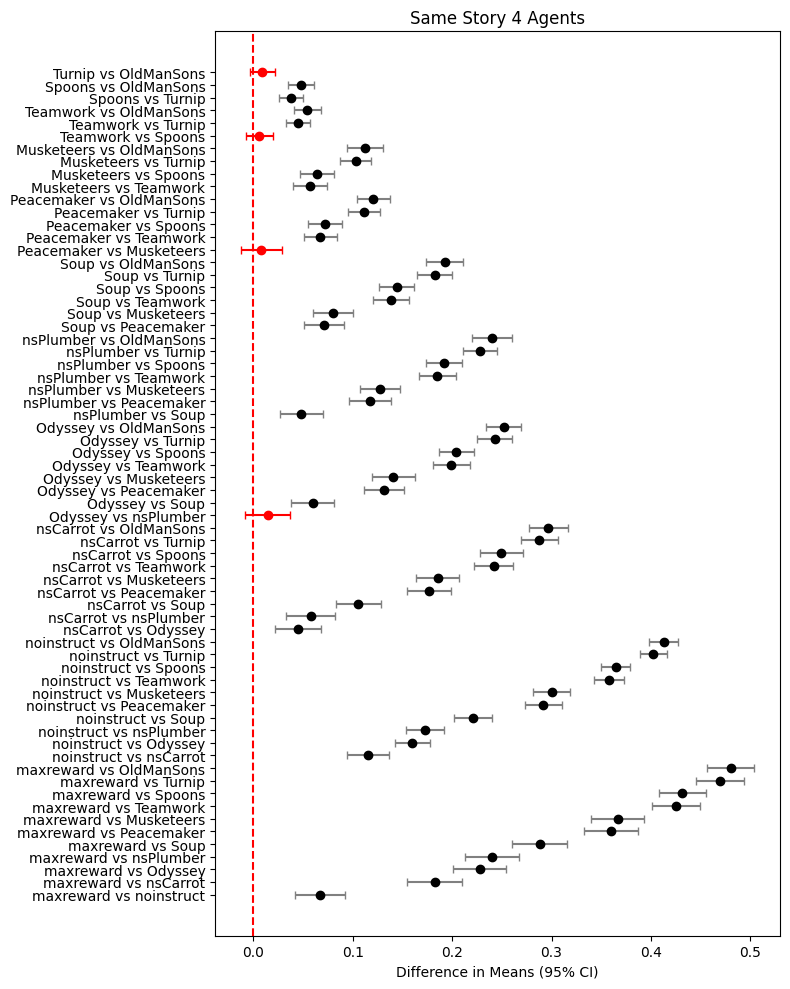

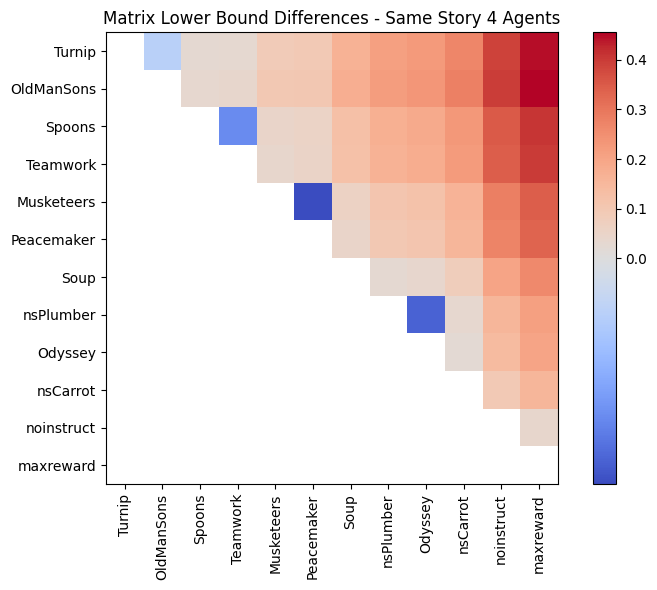

In [11]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

def analyze_collaboration_scores_all(csv_files: list):
    """
    1. Reads and combines a bundle of CSV files.
    2. For same_story and bad_apple files, filters to only final rows.
       For different_story files, uses the entire dataset.
    3. Builds a dictionary where each 'PromptType' is a key and its list of score values is the value.
       The score column is determined from the first file:
           - If "different_story" in filename, use 'CumulativePayoff'
           - Otherwise, use 'CollaborationScore'
    4. Derives a subtitle and output filename suffix from the first CSV file.
    5. Determines the fixed pair ordering to use.
    6. Calls analyze_data with the built dictionary and fixed pair ordering.
    """
    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        dfs.append(df)
    combined_df = pd.concat(dfs, ignore_index=True)

    if "Round" in combined_df.columns:
        combined_df["Round"] = combined_df["Round"].astype(str).str.lower().str.strip()

    first_csv = os.path.basename(csv_files[0]).lower()
    if "different_story" in first_csv:
        score_column = "CumulativePayoff"
        used_df = combined_df
    else:
        score_column = "CollaborationScore"
        used_df = combined_df[combined_df["Round"] == "final"].copy()
        used_df[score_column] = pd.to_numeric(used_df[score_column], errors="coerce")
        used_df.dropna(subset=[score_column], inplace=True)

    data_dict = {}
    for story, group in used_df.groupby("PromptType"):
        data_dict[story] = group[score_column].tolist()
    print("Data dictionary (PromptType: number of scores):")
    for key, scores in data_dict.items():
        print(f"{key}: {len(scores)}")

    if "different_story" in first_csv:
         subtitle = "Different Story 4 Agents"
    elif "bad_apple" in first_csv:
         subtitle = "Same Story Robust 4 Agents"
    elif "same_story" in first_csv:
         if "ag4" in first_csv:
             subtitle = "Same Story 4 Agents"
         elif "ag16" in first_csv:
             subtitle = "Same Story 16 Agents"
         elif "ag32" in first_csv:
             subtitle = "Same Story 32 Agents"
         else:
             subtitle = "Same Story"
    else:
         subtitle = first_csv

    if first_csv.startswith("game_results_"):
        full_suffix = first_csv[len("game_results_"):-len(".csv")]
    else:
        full_suffix = first_csv[:-len(".csv")]
    tokens = full_suffix.split('_')
    if len(tokens) >= 3 and tokens[0].lower() in ["same", "bad"]:
        bundle_key = "_".join(tokens[:2] + tokens[3:])
    else:
        bundle_key = full_suffix

    if "Spoons" in data_dict:
        fixed_pairs = fixed_pairs_regular
    else:
        if "temp0.6" in first_csv:
            fixed_pairs = fixed_pairs_temp
        else:
            fixed_pairs = fixed_pairs_regular

    if "different_story" in first_csv:
        fixed_pairs = None

    csv_output = "combined_pairwise_confidence_intervals_" + bundle_key + ".csv"
    ci_plot_output = "combined_pairwise_CI_plot_" + bundle_key + ".png"
    matrix_plot_output = "combined_pairwise_matrix_" + bundle_key + ".png"

    analyze_data(data_dict,
                 csv_filename=csv_output,
                 ci_plot_filename=ci_plot_output,
                 matrix_plot_filename=matrix_plot_output,
                 n_bootstrap=1000,
                 subtitle=subtitle,
                 fixed_pairs=fixed_pairs)

if __name__ == "__main__":
    all_files = glob.glob("game_results_*.csv")
    if not all_files:
        print("No game_results CSV files found.")
    else:
        bundles = {}
        for csv_file in all_files:
            base = os.path.basename(csv_file)
            if base.startswith("game_results_"):
                full_suffix = base[len("game_results_"):-len(".csv")]
            else:
                full_suffix = base[:-len(".csv")]
            tokens = full_suffix.split('_')
            if len(tokens) >= 3 and tokens[0].lower() in ["same", "bad"]:
                bundle_key = "_".join(tokens[:2] + tokens[3:])
            else:
                bundle_key = full_suffix
            bundles.setdefault(bundle_key, []).append(csv_file)

        for key, files in bundles.items():
            print(f"\nProcessing bundle: {key} ({len(files)} files)")
            analyze_collaboration_scores_all(files)
